## BalanceNet prototype

In [1]:
%run Setup.ipynb
%run ExtraFunctions.ipynb

[i] Loaded Parameters:
 40000 35 0.2 200 
 dataset/glove/glove.twitter.27B.200d.txt
[i] Importing Modules...


Using TensorFlow backend.


[+] Using Keras version 2.1.5
[+] Finished Importing Modules
[i] Reading from csv file...Done!
[i] Found 34359 unique tokens.
[+] Shape of data tensor: (47288, 30)
[+] Shape of label tensor: (47288, 5)
[i] Number of entries in each category:
[+] Training:
 [ 7716. 13053. 12748.  3446.   868.]
[+] Validation:
 [1927. 3244. 3190.  855.  241.]
[i] Loading GloVe from: dataset/glove/glove.twitter.27B.200d.txt ...Done.
[+] Proceeding with Embedding Matrix...[i] Completed!
[i] Finished running setup.


In [2]:
# second embedding matrix for non-static channel
embedding_matrix_ns = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_ns[i] = embedding_vector
print("Completed!")

Completed!


In [3]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

# static channel
embedding_layer_frozen = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
embedded_sequences_frozen = embedding_layer_frozen(sequence_input)

# non-static channel
embedding_layer_train = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix_ns],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences_train = embedding_layer_train(sequence_input)

First Half: LSTM > CNN

In [4]:
l_lstm1f = Bidirectional(LSTM(6,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(embedded_sequences_frozen)
l_lstm1t = Bidirectional(LSTM(6,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(embedded_sequences_train)
l_lstm1 = Concatenate(axis=1)([l_lstm1f, l_lstm1t])

In [5]:
l_conv_2 = Conv1D(filters=24,kernel_size=2,activation='relu')(l_lstm1)
l_conv_2 = Dropout(0.3)(l_conv_2)
l_conv_3 = Conv1D(filters=24,kernel_size=3,activation='relu')(l_lstm1)
l_conv_3 = Dropout(0.3)(l_conv_3)

l_conv_5 = Conv1D(filters=24,kernel_size=5,activation='relu',)(l_lstm1)
l_conv_5 = Dropout(0.3)(l_conv_5)
l_conv_6 = Conv1D(filters=24,kernel_size=6,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(l_lstm1)
l_conv_6 = Dropout(0.3)(l_conv_6)

l_conv_8 = Conv1D(filters=24,kernel_size=8,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(l_lstm1)
l_conv_8 = Dropout(0.3)(l_conv_8)

conv_1 = [l_conv_6,l_conv_5, l_conv_8,l_conv_2,l_conv_3]

l_lstm_c = Concatenate(axis=1)(conv_1)

Second Half: CNN > LSTM

In [6]:
l_conv_4f = Conv1D(filters=12,kernel_size=4,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(embedded_sequences_frozen)
l_conv_4f = Dropout(0.3)(l_conv_4f)
l_conv_4t = Conv1D(filters=12,kernel_size=4,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(embedded_sequences_train)
l_conv_4t = Dropout(0.3)(l_conv_4t)

l_conv_3f = Conv1D(filters=12,kernel_size=3,activation='relu',)(embedded_sequences_frozen)
l_conv_3f = Dropout(0.3)(l_conv_3f)
l_conv_3t = Conv1D(filters=12,kernel_size=3,activation='relu',)(embedded_sequences_train)
l_conv_3t = Dropout(0.3)(l_conv_3t)

l_conv_2f = Conv1D(filters=12,kernel_size=2,activation='relu')(embedded_sequences_frozen)
l_conv_2f = Dropout(0.3)(l_conv_2f)
l_conv_2t = Conv1D(filters=12,kernel_size=2,activation='relu')(embedded_sequences_train)
l_conv_2t = Dropout(0.3)(l_conv_2t)

conv_2 = [l_conv_4f, l_conv_4t,l_conv_3f, l_conv_3t, l_conv_2f, l_conv_2t]

l_merge_2 = Concatenate(axis=1)(conv_2)
l_c_lstm = Bidirectional(LSTM(12,return_sequences=True,dropout=0.3, recurrent_dropout=0.0))(l_merge_2)

Combine both halfs of the model

In [7]:
l_merge = Concatenate(axis=1)([l_lstm_c, l_c_lstm])
l_pool = MaxPooling1D(4)(l_merge)
l_drop = Dropout(0.5)(l_pool)
l_flat = Flatten()(l_drop)
l_dense = Dense(26, activation='relu')(l_flat)
preds = Dense(5, activation='softmax')(l_dense)

In [8]:
model = Model(sequence_input, preds)
adadelta = optimizers.Adadelta(lr=0.9, rho=0.95, epsilon=None, decay=0.002)
lr_metric = get_lr_metric(adadelta)
model.compile(loss='categorical_crossentropy',
              optimizer=adadelta,
              metrics=['acc'])

In [9]:
!rm -r logs

rm: cannot remove 'logs': No such file or directory


In [10]:
tensorboard = callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=16, write_grads=True , write_graph=True)
model_checkpoints = callbacks.ModelCheckpoint("checkpoint-{val_loss:.3f}.h5", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=0)
lr_schedule = callbacks.LearningRateScheduler(initial_boost)

In [11]:
model.summary()
model.save('Intialmodel.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 200)      6872000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 30, 200)      6872000     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 30, 12)       9936        embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectio

In [14]:
model = keras.models.load_model("checkpoint-0.910.h5")

Time to train!!

In [16]:
print("Training Progress:")
model_log = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=1, batch_size=256,
          callbacks=[tensorboard, model_checkpoints])


Training Progress:
Train on 37831 samples, validate on 9457 samples
Epoch 1/1
37831/37831 [==============================] - 71s 2ms/step - loss: 0.9192 - acc: 0.6242 - val_loss: 0.8849 - val_acc: 0.6432


NameError: name 'pandas' is not defined

## Model Testing and Inference

In [17]:
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
%config InlineBackend.figure_format = 'retina'
import itertools, pickle

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

classes = ["neutral", "happy", "sad", "hate","anger"]

In [18]:
! ls

BalanceNet-1.0.ipynb  _config.yml	    images	       README.md
BalanceNet.h5	      data.csv		    logs	       Setup.ipynb
checkpoint-0.885.h5   dataset		    Predict.ipynb      tokenizer.pickle
checkpoint-0.910.h5   ExtraFunctions.ipynb  ProcessData.ipynb


In [19]:
#model_test = load_model('checkpoint-0.866.h5')
model_test = load_model('checkpoint-0.910.h5')
Y_test = np.argmax(y_val, axis=1) # Convert one-hot to index
y_pred = model_test.predict(x_val)
y_pred_class = np.argmax(y_pred,axis=1)
cnf_matrix = confusion_matrix(Y_test, y_pred_class)

In [20]:
print(classification_report(Y_test, y_pred_class, target_names=classes))

             precision    recall  f1-score   support

    neutral       0.51      0.36      0.42      1927
      happy       0.66      0.72      0.69      3244
        sad       0.62      0.72      0.67      3190
       hate       0.88      0.69      0.77       855
      anger       0.92      0.69      0.79       241

avg / total       0.64      0.65      0.64      9457



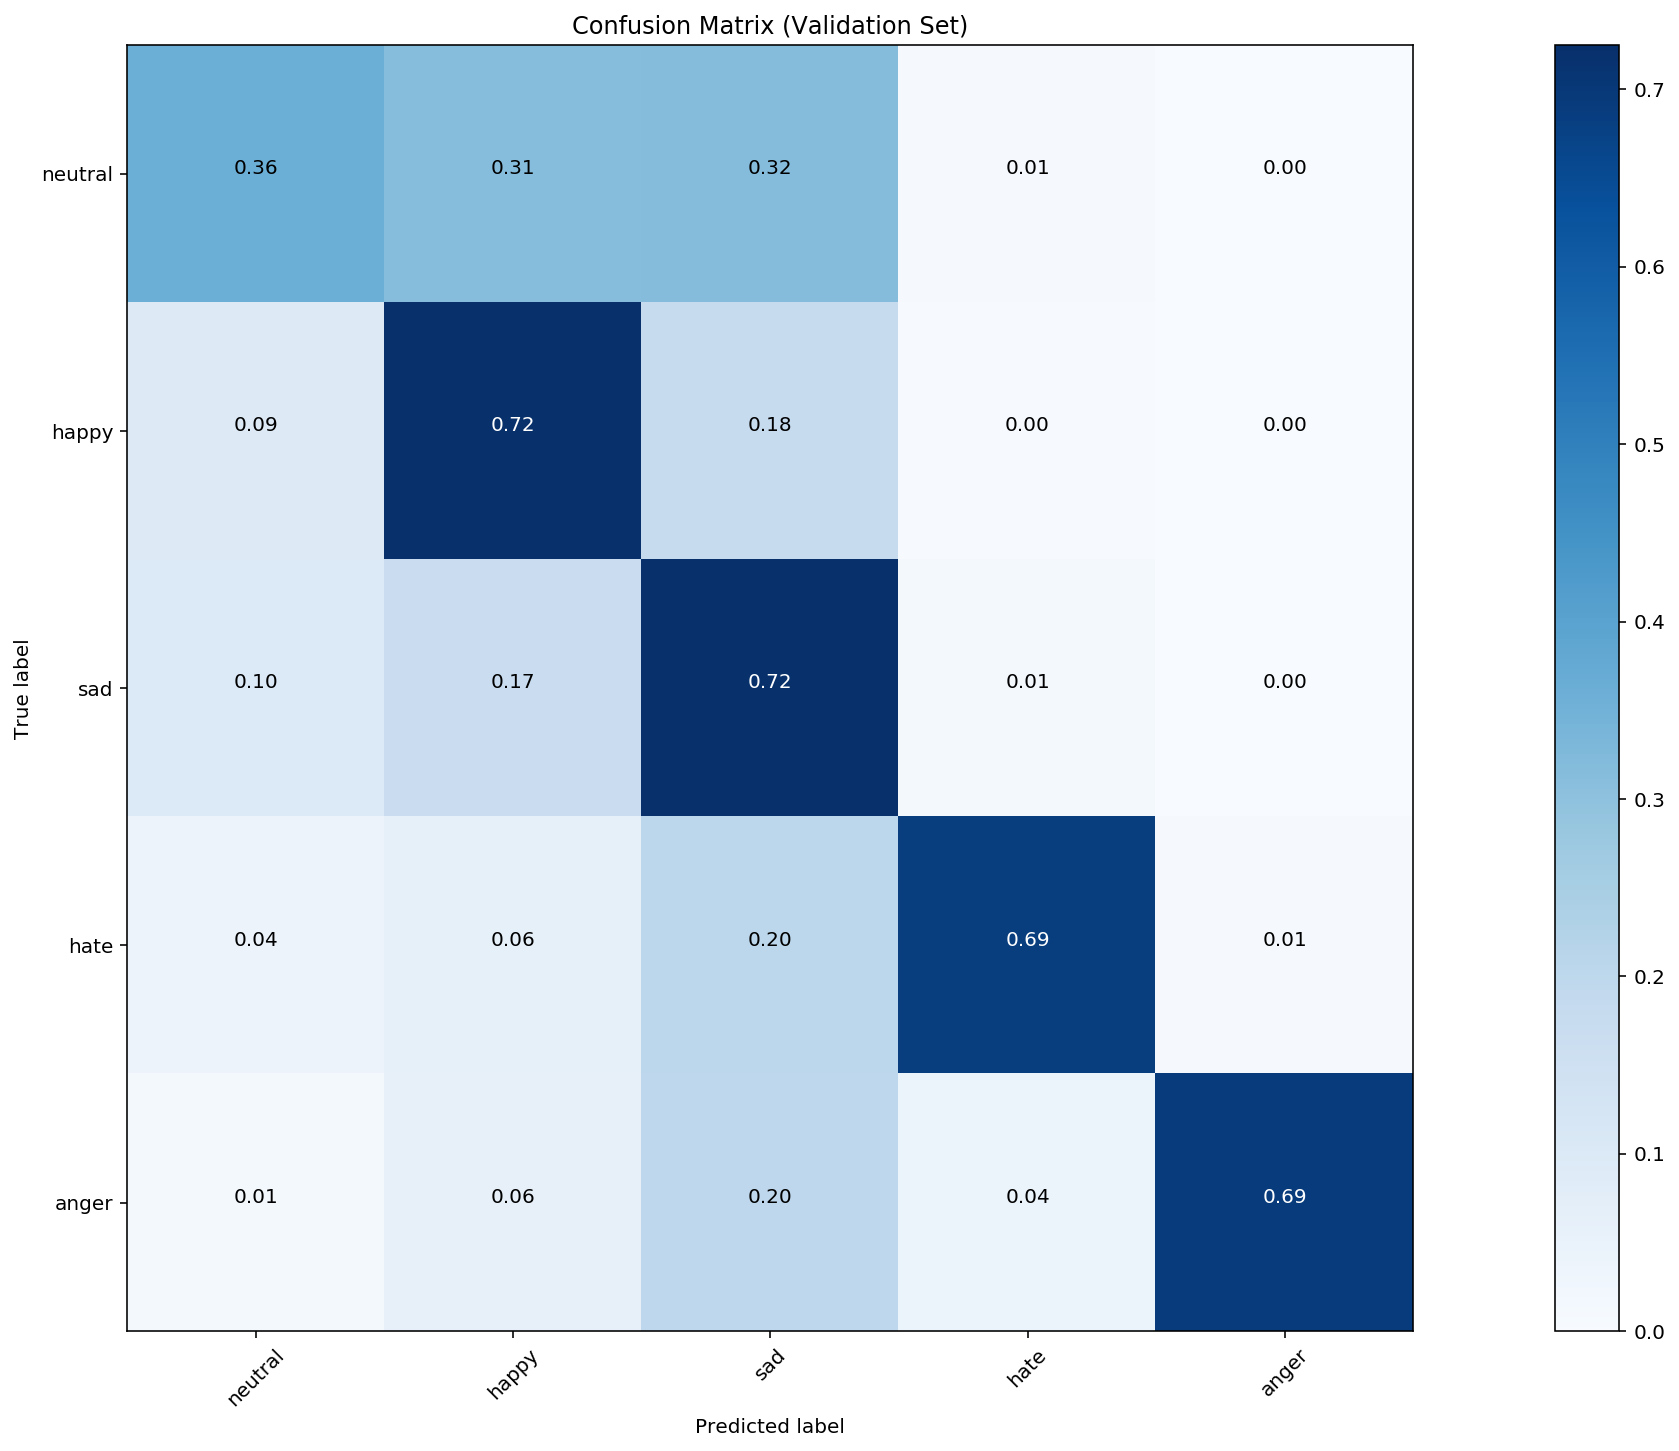

In [21]:
def plot_confusion_matrix(cm, labels,
                          normalize=True,
                          title='Confusion Matrix (Validation Set)',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix, labels=classes)

# precision = true_pos / (true_pos + false_pos)
# recall = true_pos / (true_pos + false_neg)

In [33]:
text = ["I salute you for the bravery and sacrifice! A true hero indeed.",
        "I am sorry but I trust HRW I damned sight more than the PAP and it's cronies! Off course the PAP will say that they (HRW) made things up...despite of the fact that SG is a dictator state!?",
        "PAP are taking the piss again!",
        "Thought he sold his kidney to buy it; Instead, he bought a kidney then bought the car Filthy rich This is why we need communism",
        "Somebody needs to water Tharman's head, hair needs to be grown there",
        "what a nuisance fk. a proper clean and flat footpath,,now obstructed by sharedbikes..! which idiotic MP allowed this to happen?",
        "What baby bonus scheme ??? To grow up a kid in Singapore you think is easy now bo ??? Both parent need to work to grow up a kid until 21 , you think tats easy bo ??? Think la"
       ]

In [34]:
sequences_test = tokenizer.texts_to_sequences(text)
data_int_t = pad_sequences(sequences_test, padding='pre', maxlen=(MAX_SEQUENCE_LENGTH-5))
data_test = pad_sequences(data_int_t, padding='post', maxlen=(MAX_SEQUENCE_LENGTH))
y_prob = model.predict(data_test)
for n, prediction in enumerate(y_prob):
    pred = y_prob.argmax(axis=-1)[n]
    print(text[n],"\nPrediction:",classes[pred],"\n")

I salute you for the bravery and sacrifice! A true hero indeed. 
Prediction: happy 

I am sorry but I trust HRW I damned sight more than the PAP and it's cronies! Off course the PAP will say that they (HRW) made things up...despite of the fact that SG is a dictator state!? 
Prediction: sad 

PAP are taking the piss again! 
Prediction: sad 

Thought he sold his kidney to buy it; Instead, he bought a kidney then bought the car Filthy rich This is why we need communism 
Prediction: hate 

Somebody needs to water Tharman's head, hair needs to be grown there 
Prediction: sad 

what a nuisance fk. a proper clean and flat footpath,,now obstructed by sharedbikes..! which idiotic MP allowed this to happen? 
Prediction: sad 

What baby bonus scheme ??? To grow up a kid in Singapore you think is easy now bo ??? Both parent need to work to grow up a kid until 21 , you think tats easy bo ??? Think la 
Prediction: sad 



In [36]:
np.array(sequences_test[0])

array([   1, 6097,    5,   12,    3,    6, 4841,    4,  515, 1476, 1238])